<a href="https://colab.research.google.com/github/Ghisbe/Alertas_pictogramas/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes neuronales recurrentes.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install tensorflow

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import gdown
import tensorflow as tf
print(tf.__version__)

2.15.0


In [7]:
url = "https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu"

In [8]:
output = 'alertas_lemma.csv'
gdown.download(url, output, quiet=False)

# Leer el archivo CSV en un DataFrame de pandas
alertas = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu
From (redirected): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu&confirm=t&uuid=b2246aa2-5c0d-44eb-87b2-f44badd8b805
To: /content/alertas_lemma.csv
100%|██████████| 143M/143M [00:01<00:00, 75.2MB/s]


In [9]:
alertas.head(2)

,id,event,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi..."


In [10]:
# Codificación de etiquetas
label_encoder = LabelEncoder()
alertas['label'] = label_encoder.fit_transform(alertas['event'])

In [11]:
# Dividir los datos
train_texts, val_texts, train_labels, val_labels = train_test_split(alertas['lemmatized_description'], alertas['label'], test_size=0.2, random_state=42)

In [12]:
print("Cantidad de datos de entrenamiento:", len(train_texts))
print("Cantidad de datos de validación:", len(val_texts))

Cantidad de datos de entrenamiento: 33660
Cantidad de datos de validación: 8416


In [13]:
# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

In [14]:
# Padding de secuencias
max_len = 100  # Longitud máxima de la secuencia
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

In [15]:
# Preparar las oraciones para el entrenamiento
sentences = [text.split() for text in train_texts]
# Inicializar y entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

In [16]:
# Crear la matriz de embeddings
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

print("Matriz de embeddings creada con éxito.")

Matriz de embeddings creada con éxito.


In [17]:
# Construcción del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

In [18]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix], trainable=False))  # Usamos los embeddings preentrenados
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2))  # Elimina recurrent_dropout para usar cuDNN
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          863900    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 982180 (3.75 MB)
Trainable params: 118280 (462.03 KB)
Non-trainable params: 863900 (3.30 MB)
_________________________________________________________________


In [19]:
# Entrenamiento del modelo
history = model.fit(train_padded, np.array(train_labels), validation_data=(val_padded, np.array(val_labels)), epochs=20, batch_size=16)

Epoch 1/20
2104/2104 [==============================] - 180s 84ms/step - loss: 1.0304 - accuracy: 0.6209 - val_loss: 1.0087 - val_accuracy: 0.6268
Epoch 2/20
2104/2104 [==============================] - 174s 82ms/step - loss: 1.0221 - accuracy: 0.6212 - val_loss: 1.0083 - val_accuracy: 0.6268
Epoch 3/20
2104/2104 [==============================] - 173s 82ms/step - loss: 1.0216 - accuracy: 0.6212 - val_loss: 1.0125 - val_accuracy: 0.6268
Epoch 4/20
2104/2104 [==============================] - 163s 78ms/step - loss: 1.0211 - accuracy: 0.6212 - val_loss: 1.0075 - val_accuracy: 0.6268
Epoch 5/20
2104/2104 [==============================] - 163s 78ms/step - loss: 1.0207 - accuracy: 0.6212 - val_loss: 1.0060 - val_accuracy: 0.6268
Epoch 6/20
2104/2104 [==============================] - 163s 77ms/step - loss: 1.0201 - accuracy: 0.6212 - val_loss: 1.0066 - val_accuracy: 0.6268
Epoch 7/20
2104/2104 [==============================] - 164s 78ms/step - loss: 1.0204 - accuracy: 0.6212 - val_loss: 1

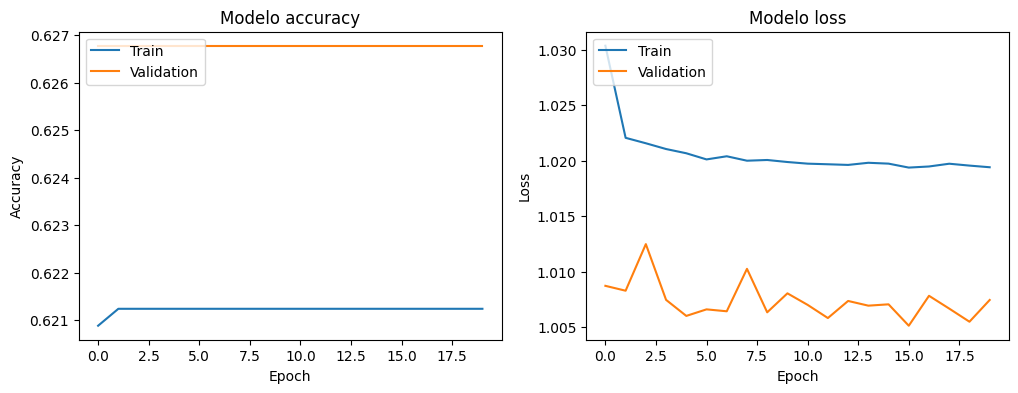

In [20]:
#Visualizacion del entrenamiento y validacion de accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Visualizacion del entrenamiento y validacion de loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
#Evaluación
loss, accuracy = model.evaluate(val_padded, np.array(val_labels))
print(f'Loss: {loss}, Accuracy: {accuracy}')

263/263 [==============================] - 14s 50ms/step - loss: 1.0075 - accuracy: 0.6268
Loss: 1.0074595212936401, Accuracy: 0.6267822980880737


In [22]:
# Matriz de confusión y reporte de clasificación
val_predictions = model.predict(val_padded)
val_predictions = np.argmax(val_predictions, axis=1)
cm = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=label_encoder.classes_))

263/263 [==============================] - 15s 56ms/step
Confusion Matrix:
[[   0    0    0    0    0    0   45    0]
 [   0    0    0    0    0    0   51    0]
 [   0    0    0    0    0    0  390    0]
 [   0    0    0    0    0    0  116    0]
 [   0    0    0    0    0    0  110    0]
 [   0    0    0    0    0    0   66    0]
 [   0    0    0    0    0    0 5275    0]
 [   0    0    0    0    0    0 2363    0]]
Classification Report:
                        precision    recall  f1-score   support

    Dust Storm Warning       0.00      0.00      0.00        45
     Ice Storm Warning       0.00      0.00      0.00        51
         Storm Warning       0.00      0.00      0.00       390
           Storm Watch       0.00      0.00      0.00       116
Tropical Storm Warning       0.00      0.00      0.00       110
  Tropical Storm Watch       0.00      0.00      0.00        66
  Winter Storm Warning       0.63      1.00      0.77      5275
    Winter Storm Watch       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#Lista de posibles eventos
eventos = ['Dust Storm Warning', 'Tropical Storm Warning',
       'Winter Storm Warning', 'Winter Storm Watch',
       'Tropical Storm Watch', 'Storm Warning', 'Storm Watch',
       'Ice Storm Warning']

In [24]:
# Función predict
def predict(texts):
    predictions = np.random.choice(eventos, size=len(texts))  # Usar la lista de posibles eventos
    return predictions

# Función random_prediction
def random_prediction(alertas, n=1):
    random_indices = np.random.choice(alertas.index, size=n, replace=False)  # Seleccionar índices aleatorios
    random_descriptions = alertas.loc[random_indices, 'description'].values
    predictions = predict(random_descriptions)
    result = list(zip(random_descriptions, predictions))  # Emparejar descripciones y predicciones
    return result

In [28]:
# Llamar a la función random_prediction
predictions = random_prediction(alertas, n=1)
for description, prediction in predictions:
    print(f'Description: {description}')
    print(f'Prediction: {prediction}')

Description:  locations include the cities of buford trappers lake   timing expect prolonged periods of light to moderate snow    showers through monday night   snow accumulation an additional four to eight inches for a storm    total of eight to sixteen inches with up to twenty inches on favored west    facing slopes above nine thousand feet   impacts mountain roadways will become icy and snow packed    persistent snow through monday night will keep hazardous    travel conditions in place
Prediction: Storm Warning


#Creacion de pictogramas.

Un pictograma es un símbolo gráfico que transmite información o datos mediante una representación clara y simplificada ya que, ayudan a transmitir información de forma visual y más rápida.

In [29]:
pip install pillow

In [30]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

In [31]:
def create_pictogram(description, event):
    # Crear una imagen en blanco
    img = Image.new('RGB', (300, 300), color=(255, 255, 255))
    d = ImageDraw.Draw(img)

    # Definir la fuente
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    # Dibujar el pictograma basado en el evento
    if event == 'Dust Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Asteriscos amarillos
        for _ in range(50):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="yellow", font=font)
    elif event == 'Tropical Storm Warning':
        # Triángulo rojo con centro blanco
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")
        d.polygon([(120, 140), (180, 140), (150, 90)], fill="white", outline="black")
        # Espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
    elif event == 'Winter Storm Warning' or event == 'Ice Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Asteriscos de color azul (simulando nieve)
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
    elif event == 'Winter Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Asteriscos de color azul (simulando nieve)
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
    elif event == 'Tropical Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
    elif event == 'Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="black", width=2)
    elif event == 'Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="black", width=2)

    # Convertir la imagen a un array numpy
    img_array = np.array(img)

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()


Descripción:  snow showers for higher mountain elevations into tuesday   late season pacific storm will continue to bring periods of moderate snow showers to the higher elevations of the sierra nevada into tuesday  travel into the sierra should be avoided during this time with periods as slick roads lowered visibility travel delays and chain controls are expected   what heavy snow occurring plan on difficult travel conditions including during the evening commute on tuesday additional snow accumulations of up to one inch are expected   where west slope northern sierra nevada   when until five pm tuesday   additional details be prepared for significant reductions in visibility at times
Evento: Winter Storm Warning


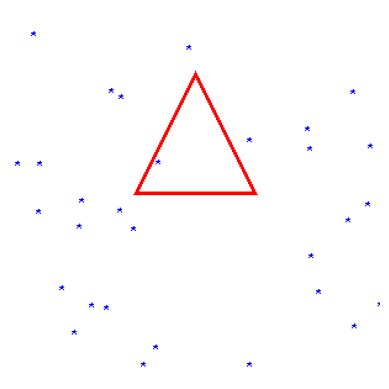

In [33]:
#obtener la descripción y el evento de una fila en el dataframe
row_index = 4  # Índice numérico de la fila en el dataframe
description = alertas.iloc[row_index]['description']
event = alertas.iloc[row_index]['event']

#descripción y el evento para verificar
print("Descripción:", description)
print("Evento:", event)

#Crear el pictograma
create_pictogram(description, event)